In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.stats import norm

from gammapy.cube import MapDataset, MapDatasetEventSampler, MapDatasetMaker, SafeMaskMaker
#from gammapy.cube.tests.test_fit import get_map_dataset
from gammapy.data import GTI, Observation, EventList
from gammapy.maps import MapAxis, WcsGeom, WcsNDMap
from gammapy.irf import load_cta_irfs
from gammapy.modeling import Fit
from gammapy.modeling.models import (
                                     PointSpatialModel,
                                     GaussianSpatialModel,
                                     PowerLawSpectralModel,
                                     SkyModel,
                                     SkyModels,
                                     )



In [4]:
from gammapy.spectrum import (
    SpectrumDatasetMaker,
    SpectrumDatasetOnOff,
    SpectrumDataset,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)

In [17]:
exp = 10.0
src_morph = 'point'
src_spec = 'pwl'

path = "$GAMMAPY_VALIDATION/gammapy-benchmarks/validation/event-sampling/"

model_path = "/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling/models/"+src_morph+"-"+src_spec+"/"+src_morph+"-"+src_spec+".yaml"
model_fit_path = "/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling/results/models/"+src_morph+"-"+src_spec+"/"+src_morph+"-"+src_spec+".yaml"
dataset_path = path+"/data/models/"+src_morph+"-"+src_spec+"/dataset_"+str(int(exp))+"hr.fits.gz"
events_path = path+"/models/"+src_morph+"-"+src_spec+"/events_"+str(int(exp))+"hr.fits.gz"


##############

ENERGY_AXIS = MapAxis.from_bounds(0.1, 300, nbin=30, unit="TeV", name="energy", interp="log")
ENERGY_AXIS_TRUE = MapAxis.from_bounds(0.1, 300, nbin=30, unit="TeV", name="energy", interp="log")

position = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
WCS_GEOM = WcsGeom.create(skydir=(0, 0), width=(6, 6), binsz=0.02, coordsys="GAL", axes=[ENERGY_AXIS])

livetime = exp * u.hr
t_min = 0 * u.s
t_max = livetime.to(u.s) #50 hr


In [32]:
def prepare_dataset():
    # read irfs create observation with a single pointing
    # choose some geom, rather fine energy binnning at least 10 bins / per decade
    # computed reduced dataset see e.g. https://docs.gammapy.org/0.15/notebooks/simulate_3d.html#Simulation
    # write dataset to data/dataset-{livetime}.fits.gz
    
#    irfs = load_cta_irfs(
#                         "$GAMMAPY_DATA/cta-prod3b/caldb/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
#                )
    irfs = load_cta_irfs(
                     "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
                     )

    observation = Observation.create(obs_id=1001, pointing=position, livetime=livetime, irfs=irfs)

    empty = MapDataset.create(WCS_GEOM)
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
    dataset = maker.run(empty, observation)
    dataset = maker_safe_mask.run(dataset, observation)

    gti = GTI.create(start=t_min, stop=t_max)
    dataset.gti = gti

    dataset.write(path+"/data/models/"+src_morph+"-"+src_spec+"/dataset_"+str(int(exp))+"hr.fits.gz", overwrite=True)

    return observation

def simulate_events(dataset, model, observation):
    # read dataset using MapDataset.read()
    # read model from model.yaml using SkyModels.read()
    # set the model on the dataset write
    # simulate events and write them to data/models/your-model/events-1.fits
    # optionally : bin events here and write counts map to data/models/your-model/counts-1.fits
    
    dataset = MapDataset.read(dataset)
    
    model_simu = SkyModels.read(model)
    dataset.models = model_simu
    
    events = MapDatasetEventSampler(random_state=0)
    events = events.run(dataset, observation)
    
    events.table.write("/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling/models/"+src_morph+"-"+src_spec+"/events_"+str(int(exp))+"hr.fits.gz", overwrite=True)

    return events

#    pass

def fit_model(dataset, events, model):
    # read dataset using MapDataset.read()
    # read events using EventList.read()
    # bin events into datasets using WcsNDMap.fill_events(events)
    # read reference model and set it on the dataset
    # fit and write best-fit model
    
#    dataset = MapDataset.read(dataset_path)
#    event = EventList.read(events_path)
#    model_simu = SkyModels.read(model_path)
    dataset = MapDataset.read(dataset)
    event = EventList.read(events)
    model_simu = SkyModels.read(model)
    model_fit = SkyModels.read(model)

#    model_fit = model_simu[0].copy
    dataset.models = model_fit
    dataset.fake()
    
    background_model = dataset.background_model
    background_model.parameters["norm"].value = 1.0
    background_model.parameters["norm"].frozen = True
    background_model.parameters["tilt"].frozen = True

    fit = Fit([dataset])
    result = fit.run(optimize_opts={"print_level": 1})

    print("True model: \n", model_simu, "\n\n Fitted model: \n", model_fit)
    result.parameters.to_table()

    covar = result.parameters.get_subcovariance(model_fit[0].spectral_model.parameters)
    
    model_fit.write(path+"/results/models/"+src_morph+"-"+src_spec+"/"+src_morph+"-"+src_spec+".yaml", overwrite=True)

    return covar
#    pass

def plot_results(dataset, model, best_fit_model, covar_matrix):
    # read model and best-fit model
    # write to results folder
    # compare the spectra
    # plot summed residuals
    # plot residual significance distribution and check for normal distribution
    # compare best fit values by writting to model.yaml

    model = SkyModels.read(model)
    best_fit_model = SkyModels.read(best_fit_model)
    best_fit_model[0].spectral_model.parameters.covariance = covar_matrix

    # plot spectral models
    ax1 = model[0].spectral_model.plot(energy_range=(0.1,300)*u.TeV, label='Sim. model')
    ax2 = best_fit_model[0].spectral_model.plot(energy_range=(0.1,300)*u.TeV, label='Best-fit model')
    ax3 = best_fit_model[0].spectral_model.plot_error(energy_range=(0.1,300)*u.TeV)
    ax1.legend()
    ax2.legend()
    plt.savefig("/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling/results/models/"+src_morph+"-"+src_spec+"/"+src_morph+"-"+src_spec+"_"+str(int(exp))+"hr.eps", format='eps', dpi=100)
    plt.gcf().clear()
    plt.close

    # plot residuals
    dataset = MapDataset.read(dataset)
    dataset.models = best_fit_model
    dataset.fake()
    dataset.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)
    plt.savefig("/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling/results/models/"+src_morph+"-"+src_spec+"/"+src_morph+"-"+src_spec+"_"+str(int(exp))+"hr_residuals.eps", format='eps', dpi=100)
    plt.gcf().clear()
    plt.close
    
    # plot residual significance distribution
    resid = dataset.residuals()
    sig_resid = resid.data[np.isfinite(resid.data)]
    
    plt.hist(
             sig_resid,
             density=True,
             alpha=0.5,
             color="red",
             bins=100,
             )
             
    mu, std = norm.fit(sig_resid)
    print("Fit results: mu = {:.2f}, std = {:.2f}".format(mu, std))
    x = np.linspace(-8, 8, 50)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, lw=2, color="black")
    plt.legend()
    plt.xlabel("Significance")
    plt.yscale("log")
    plt.ylim(1e-5, 1)
    xmin, xmax = np.min(sig_resid), np.max(sig_resid)
    plt.xlim(xmin, xmax)
    plt.savefig("/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling/results/models/"+src_morph+"-"+src_spec+"/"+src_morph+"-"+src_spec+"_"+str(int(exp))+"hr_resid_distrib.eps", format='eps', dpi=1000)
    plt.gcf().clear()
    plt.close
    
    pass


In [12]:
observation = prepare_dataset()
simulate_events(dataset_path, model_path, observation)

In [13]:
covar = fit_model(dataset_path, events_path, model_path)

------------------------------------------------------------------
| FCN = 1.249E+06               |      Ncalls=76 (76 total)      |
| EDM = 6.09E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
True model: 
 SkyModels

Component 0: SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 

In [33]:
plot_results(dataset_path, model_path, model_fit_path, covar)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists

Fit results: mu = -0.00, std = 0.55


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

In [21]:
model = SkyModels.read(model_path)
best_fit_model = SkyModels.read(model_fit_path)
best_fit_model[0].spectral_model.parameters.covariance = covar

In [22]:
ax1 = model[0].spectral_model.plot(energy_range=(0.1,300)*u.TeV, label='Sim. model')
ax2 = best_fit_model[0].spectral_model.plot(energy_range=(0.1,300)*u.TeV, label='Best-fit model')
ax3 = best_fit_model[0].spectral_model.plot_error(energy_range=(0.1,300)*u.TeV)
ax1.legend()
ax2.legend()
plt.savefig("/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling/results/models/"+src_morph+"-"+src_spec+"/"+src_morph+"-"+src_spec+"_"+str(int(exp))+"hr.eps", format='eps', dpi=1000)
plt.gcf().clear()
plt.close

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<function matplotlib.pyplot.close(fig=None)>

<Figure size 432x288 with 0 Axes>

In [25]:
dataset = MapDataset.read(dataset_path)

In [29]:
dataset.models = best_fit_model
dataset.fake()
dataset.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)
plt.savefig("/Users/fabio/LAVORO/CTA/GAMMAPY/GIT/gammapy-benchmarks/validation/event-sampling/results/models/"+src_morph+"-"+src_spec+"/"+src_morph+"-"+src_spec+"_"+str(int(exp))+"hr_residuals.eps", format='eps', dpi=100)
plt.gcf().clear()
plt.close

/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<function matplotlib.pyplot.close(fig=None)>

<Figure size 864x288 with 0 Axes>

In [19]:
model = SkyModels.read(model_path)
model_fit[0].spectral_model.parameters.covariance = covar
dataset = MapDataset.read(dataset_path)
dataset.models = model_fit


/anaconda2/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<matplotlib.axes._subplots.WCSAxesSubplot at 0x1c2027ff28>, None)

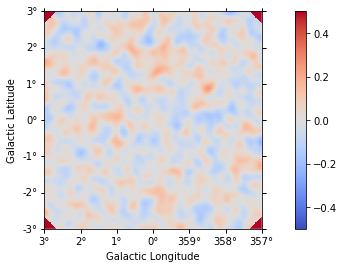

In [21]:
dataset.fake()
dataset.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)


In [10]:
a.copy

<bound method SkyModel.copy of SkyModel(spatial_model=<gammapy.modeling.models.spatial.PointSpatialModel object at 0x1c1a2a38d0>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x1c1a299f98>)>

In [158]:
covar

array([[1.24410462e-05, 1.42118585e-17, 0.00000000e+00],
       [1.42118585e-17, 7.14371074e-28, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

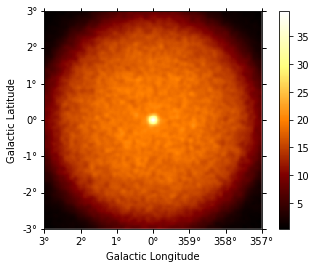

In [9]:
dataset.counts.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

In [172]:
a=dataset.residuals()

In [191]:
b=a.data[np.isfinite(a.data)]

Fit results: mu = -0.00, std = 1.23


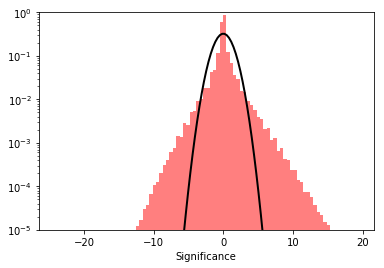

In [192]:
plt.hist(
    b,
    density=True,
    alpha=0.5,
    color="red",
    bins=100,
)

mu, std = norm.fit(b)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(b), np.max(b)
plt.xlim(xmin, xmax)

print("Fit results: mu = {:.2f}, std = {:.2f}".format(mu, std))

In [164]:
model = SkyModels.read(model_path)
model_fit[0].spectral_model.parameters.covariance = covar
ax1 = model[0].spectral_model.plot(energy_range=(0.1,300)*u.TeV, label='ciao')
ax2 = model_fit[0].spectral_model.plot(energy_range=(0.1,100)*u.TeV, label='ciao1')
ax2 = model_fit[0].spectral_model.plot_error(energy_range=(0.1,100)*u.TeV)
ax1.legend()
ax2.legend()
plt.savefig("test_gamma.eps", format='eps', dpi=1000)
plt.gcf().clear()
plt.close


<function matplotlib.pyplot.close(fig=None)>

<Figure size 432x288 with 0 Axes>

(<matplotlib.axes._subplots.WCSAxesSubplot at 0x1c23742470>, None)

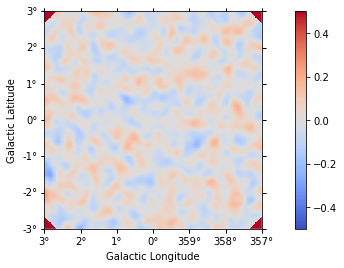

In [152]:
dataset.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

In [153]:
result.parameters.get_subcovariance(model_fit[0].spectral_model.parameters)

NameError: name 'result' is not defined

In [34]:
e_min, e_max = 0.7, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

In [37]:
fpe = FluxPointsEstimator(datasets=dataset, e_edges=e_edges)
flux_points = fpe.run()

TypeError: Invalid type: <gammapy.cube.fit.MapDataset object at 0x1c1b0606a0>

In [42]:
a=dataset.models

In [108]:
e_edges

<Quantity [ 0.7       ,  1.0192961 ,  1.48423505,  2.16124999,  3.14707669,
            4.58257569,  6.67285932,  9.71659923, 14.1487024 , 20.60245306,
           30.        ] TeV>

In [118]:
c=model_fit[0]

In [119]:
model_fit.write?

Signature: model_fit.write(path, overwrite=False)
Docstring: Write to YAML file.
File:      ~/LAVORO/CTA/GAMMAPY/GIT/gammapy/gammapy/modeling/models/cube.py
Type:      method


In [87]:
model_simu = SkyModels.read(model_path)

In [101]:
a=model_simu[0]

In [105]:
b=a.spectral_model

ValueError: not enough values to unpack (expected 2, got 1)

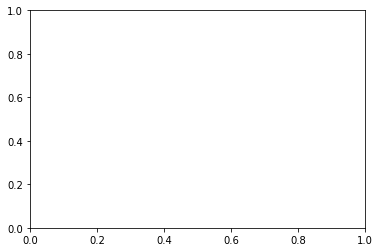

In [113]:
b.plot(energy_range=[ENERGY_AXIS])